# GA-Optimized Decision Trees: Quick Start Guide

This notebook demonstrates how to train a Decision Tree using a **Genetic Algorithm (GA)** instead of the traditional greedy CART algorithm.

### Why use a Genetic Algorithm?
Traditional decision trees are "greedy"—they pick the best immediate split at each node. This is fast but can get stuck in local optima.
A Genetic Algorithm evolves a *population* of trees over time, exploring multiple tree structures simultaneously. This allows it to potentially find globally better (or sparser) solutions that a greedy approach might miss.

**Workflow:**
1.  **Initialize**: Create a random population of trees.
2.  **Evaluate**: Calculate fitness (Accuracy - Complexity Penalty).
3.  **Selection**: Pick the best trees to be parents.
4.  **Crossover & Mutation**: Mix and modify trees to create the next generation.
5.  **Repeat**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Add source path
sys.path.insert(0, '../src')

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# GA Imports
from ga_trees.ga.engine import GAEngine, GAConfig, TreeInitializer, Mutation
from ga_trees.fitness.calculator import FitnessCalculator, TreePredictor

sns.set(style="whitegrid")
print("✓ Imports complete")

✓ Imports complete


## 1. Load Data
We will use the **Iris Dataset**, a simple benchmark for classification.

In [2]:
X, y = load_iris(return_X_y=True)
feature_names = load_iris().feature_names
target_names = load_iris().target_names

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")

Training Samples: 105
Test Samples: 45


## 2. Configure the Genetic Algorithm

The behavior of the GA is controlled by the configuration:
- `population_size`: How many trees are in each generation.
- `n_generations`: How many iterations to run.
- `mutation_prob`: Chance of a random change (e.g., changing a split threshold).
- `crossover_prob`: Chance of swapping subtrees between two parents.

**Fitness Function:**
We use a **weighted fitness** that balances accuracy and interpretability.
`Fitness = (0.7 * Accuracy) + (0.3 * Interpretability)`

In [3]:
# Setup Feature Ranges for Mutation
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
# Calculate min/max for each feature to ensure valid random splits
feature_ranges = {i: (X_train[:, i].min(), X_train[:, i].max()) 
                 for i in range(n_features)}

# 1. Configuration
ga_config = GAConfig(
    population_size=50,
    n_generations=20,      # Kept small for quick demo
    crossover_prob=0.7,
    mutation_prob=0.2,
    tournament_size=3,
    elitism_ratio=0.1      # Keep top 10% best trees unchanged
)

# 2. Initialization Strategy
initializer = TreeInitializer(
    n_features=n_features,
    n_classes=n_classes,
    max_depth=4,
    min_samples_split=5,
    min_samples_leaf=2
)

# 3. Fitness Function
fitness_calc = FitnessCalculator(
    mode='weighted_sum',
    accuracy_weight=0.7,
    interpretability_weight=0.3
)

# 4. Mutation Strategy
mutation = Mutation(n_features=n_features, feature_ranges=feature_ranges)

print("Genetic Algorithm Configured.")

Genetic Algorithm Configured.


## 3. Evolution Loop

We now run the evolution. At each generation, the engine will print the fitness statistics.
Note how the `Best` fitness improves (or stabilizes) over time as the trees optimize.

In [4]:
ga_engine = GAEngine(
    config=ga_config,
    initializer=initializer,
    fitness_function=fitness_calc.calculate_fitness,
    mutation=mutation
)

print("Starting Evolution...\n")
# Evolve returns the best individual (tree) found
best_tree = ga_engine.evolve(X_train, y_train, verbose=True)

print("\nEvolution Complete.")

Starting Evolution...

Gen 0: Best=0.8853, Avg=0.5946
Gen 10: Best=0.9153, Avg=0.8886

Evolution Complete.


## 4. Evaluation & Visualization

Let's see how our evolved tree performs on unseen data and visualize its decision logic.

Test Accuracy: 0.8889
Tree Depth: 3
Tree Nodes: 15


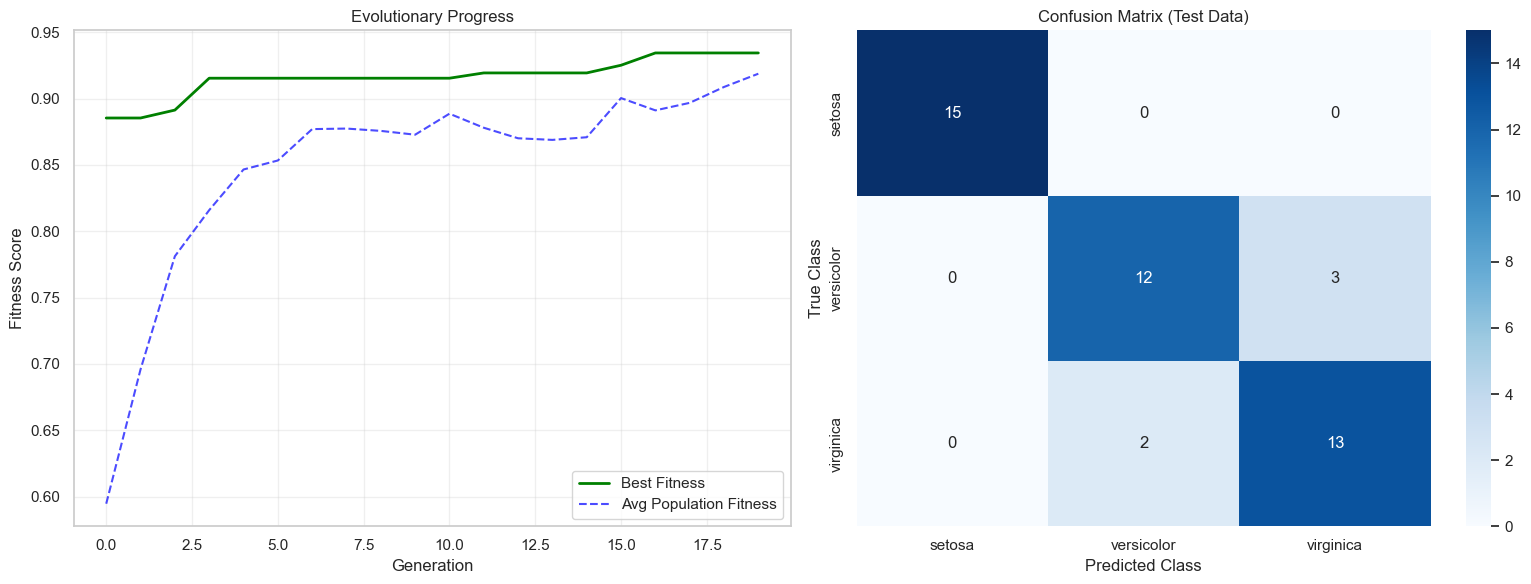

In [5]:
# Predict on Test Set
predictor = TreePredictor()
y_pred = predictor.predict(best_tree, X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {acc:.4f}")
print(f"Tree Depth: {best_tree.get_depth()}")
print(f"Tree Nodes: {best_tree.get_num_nodes()}")

# --- Visualization ---
history = ga_engine.get_history()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Fitness History
ax1.plot(history['best_fitness'], label='Best Fitness', color='green', linewidth=2)
ax1.plot(history['avg_fitness'], label='Avg Population Fitness', color='blue', linestyle='--', alpha=0.7)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness Score")
ax1.set_title("Evolutionary Progress")
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=target_names, yticklabels=target_names)
ax2.set_title("Confusion Matrix (Test Data)")
ax2.set_ylabel("True Class")
ax2.set_xlabel("Predicted Class")

plt.tight_layout()
plt.show()

Generating Decision Surface...


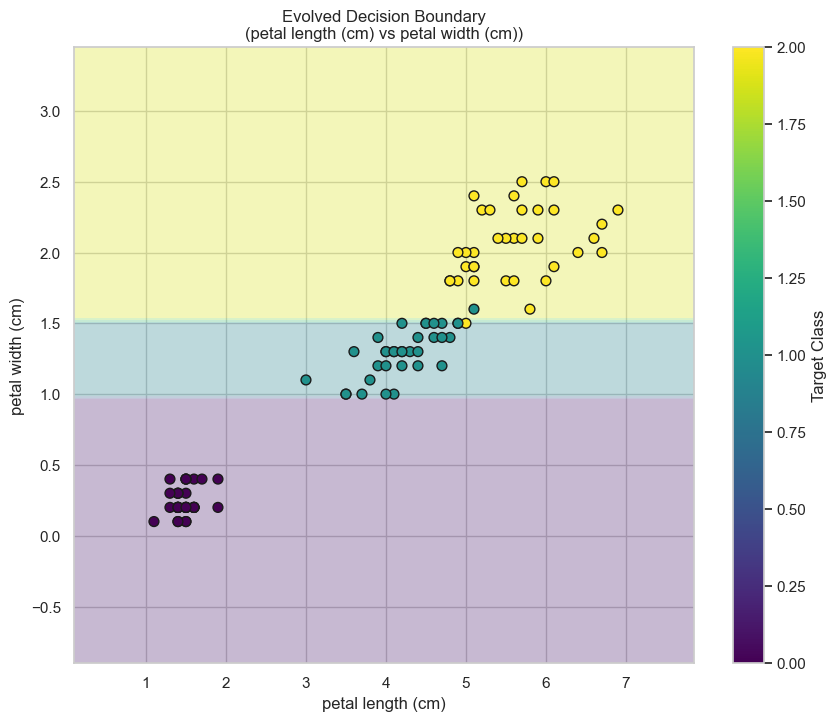

In [6]:
# --- Decision Surface Visualization ---
print("Generating Decision Surface...")

def plot_evolved_decision_surface(tree, X, y, f1_idx, f2_idx, f_names, predictor):
    """
    Visualizes decision boundaries on a 2D slice of features.
    Other features are held constant at their mean.
    """
    # Create meshgrid
    x_min, x_max = X[:, f1_idx].min() - 1, X[:, f1_idx].max() + 1
    y_min, y_max = X[:, f2_idx].min() - 1, X[:, f2_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))
    
    # Prepare input matrix for prediction
    # Set variable features to meshgrid values
    # Set other features to their mean values
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    full_input = np.zeros((mesh_points.shape[0], X.shape[1]))
    
    # Fill means first
    for i in range(X.shape[1]):
        full_input[:, i] = X[:, i].mean()
        
    # Fill visualization columns
    full_input[:, f1_idx] = mesh_points[:, 0]
    full_input[:, f2_idx] = mesh_points[:, 1]
    
    # Predict using the GA Tree Predictor
    Z = predictor.predict(tree, full_input)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    contour = plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    scatter = plt.scatter(X[:, f1_idx], X[:, f2_idx], c=y, cmap='viridis', edgecolor='k', s=50)
    plt.colorbar(scatter, label='Target Class')
    plt.xlabel(f_names[f1_idx])
    plt.ylabel(f_names[f2_idx])
    plt.title(f"Evolved Decision Boundary\n({f_names[f1_idx]} vs {f_names[f2_idx]})")
    plt.show()

# Visualize using Petal Length (2) and Petal Width (3) - usually most important for Iris
plot_evolved_decision_surface(best_tree, X_train, y_train, 2, 3, feature_names, predictor)

## 5. Rule Interpretation

One major advantage of decision trees is **interpretability**. We can translate the evolved tree directly into IF-THEN rules.

In [7]:
rules = best_tree.to_rules()
print(f"Extracted {len(rules)} Rules from Evolved Tree:\n")

for i, rule in enumerate(rules, 1):
    # Format rule string to be more readable
    clean_rule = rule
    for j, name in enumerate(feature_names):
        clean_rule = clean_rule.replace(f"X[{j}]", name)
    
    print(f"Rule {i}: {clean_rule}")

Extracted 8 Rules from Evolved Tree:

Rule 1: IF petal width (cm) <= 1.5382 AND petal width (cm) <= 0.9921 AND petal width (cm) <= 0.9921 THEN class=0
Rule 2: IF petal width (cm) <= 1.5382 AND petal width (cm) <= 0.9921 AND petal width (cm) > 0.9921 THEN class=0
Rule 3: IF petal width (cm) <= 1.5382 AND petal width (cm) > 0.9921 AND petal width (cm) <= 0.2843 THEN class=0
Rule 4: IF petal width (cm) <= 1.5382 AND petal width (cm) > 0.9921 AND petal width (cm) > 0.2843 THEN class=1
Rule 5: IF petal width (cm) > 1.5382 AND petal width (cm) <= 0.8967 AND petal width (cm) <= 0.9921 THEN class=0
Rule 6: IF petal width (cm) > 1.5382 AND petal width (cm) <= 0.8967 AND petal width (cm) > 0.9921 THEN class=0
Rule 7: IF petal width (cm) > 1.5382 AND petal width (cm) > 0.8967 AND petal width (cm) <= 0.2843 THEN class=0
Rule 8: IF petal width (cm) > 1.5382 AND petal width (cm) > 0.8967 AND petal width (cm) > 0.2843 THEN class=2


## 6. Conclusion & Modeling Implications

By using a Genetic Algorithm, we have generated a decision tree that is not strictly bound by greedy splitting criteria (like Gini/Entropy gain at every single step).

**Implications:**
1.  **Global Search**: The GA can potentially find feature combinations that a greedy tree might miss (e.g., "diagonal" logic approximated by multiple split interactions that aren't obvious individually).
2.  **Multiobjective Optimization**: Our fitness function explicitly rewards *interpretability* (shorter trees). Standard sklearn trees only minimize impurity, often leading to overfitting unless pruned.
3.  **Trade-off**: GA training is slower (Generation loop) than C4.5/CART algorithms, making it better suited for smaller datasets where optimized, interpretable models are critical.